# 1 Model Complexity and Model Selection
Student ID: 35224436 | Full name: Yiming Zhang

## 1 Question 1 KNN Regressor

import packages

In [1]:
from scipy.spatial import KDTree
from sklearn.base import BaseEstimator
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np

### Task I. KNN Regressor Implementation

In [2]:
class KnnRegressor(BaseEstimator):
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.y_train_ = np.array(y)
        self.x_train_kdtree_ = KDTree(X)
        return self

    def predict(self, X):
        # Find k nearest neighbors
        _, neighbours = self.x_train_kdtree_.query(X, k=self.k)
        neighbours = neighbours.reshape(len(X), self.k)

        # Get neighbor labels (regression targets here)
        neighbour_values = self.y_train_[neighbours]

        # Compute mean
        y_pred = neighbour_values.mean(axis=1)

        return y_pred


### Task II. Test implementation


#### Load dataset

In [3]:
# Load dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target
X.shape, y.shape

((442, 10), (442,))

#### Split dataset

In [4]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=18
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((309, 10), (133, 10), (309,), (133,))

#### Guess a K
According to the empirical rule, $\sqrt{trainingSetSize}\,$ is often close to the optimal value of K. Therefore, I estimate that K = $\sqrt{309} \approx$ 18 is an acceptable choice for K.

#### Test

In [5]:
# Test KNN Regressor
knn = KnnRegressor(k=18)
knn.fit(X_train, y_train)
y_hat_train = knn.predict(X_train)
y_hat_test = knn.predict(X_test)
y_hat_train.shape, y_hat_test.shape

((309,), (133,))

#### Evaulation
Use the sum of the squares of the errors as the error function to measure training errors and testing errors.

In [6]:
# calculate the sum of squared errors
def sse(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

#### Compute error

In [7]:
sse_train = sse(y_train, y_hat_train)
sse_test = sse(y_test, y_hat_test)
sse_train, sse_test
print(
    f"When K = 18 \nThe training error is {sse_train} \nThe testing error is {sse_test}"
)

When K = 18 
The training error is 873984.8395061729 
The testing error is 468777.64197530865


#### Further test to find optimal K
Test and find the optimal K (1~30)

In [8]:
def choose_k(X_train, y_train, X_test, y_test, max_k):
    """
    Choose the best K for KNN Regressor
    max_k: the maximum K to test
    """
    sse_train = []
    sse_test = []
    for k in range(1, max_k + 1):
        knn = KnnRegressor(k=k)
        knn.fit(X_train, y_train)
        y_hat_train = knn.predict(X_train)
        y_hat_test = knn.predict(X_test)
        sse_train.append(sse(y_train, y_hat_train))
        sse_test.append(sse(y_test, y_hat_test))
    return sse_train, sse_test


sse_train, sse_test = choose_k(X_train, y_train, X_test, y_test, 30)

# find the minimum sse_test and the corresponding k
min_sse_test = min(sse_test)
best_k = sse_test.index(min_sse_test) + 1
print(f"The minimum testing error is {min_sse_test} when K = {best_k}")
print(f"Hence, the optimal K is {best_k}")

The minimum testing error is 450863.84171597636 when K = 26
Hence, the optimal K is 26


## 2 Question 2 L-fold Cross Validation

### Task I. L-fold Implementation

In [9]:
class LFold:
    def __init__(self, L=5, random_state=None, shuffle=False):
        self.L = L
        self.random_state = random_state
        self.shuffle = shuffle

    def get_n_splits(self):
        return self.L

    def split(self, x, y=None, groups=None):
        n_samples = len(x)
        indices = np.arange(n_samples)  # indexes of samples

        if self.shuffle:
            rng = np.random.RandomState(self.random_state)
            rng.shuffle(indices)

        # calculate the size of each fold
        fold_size = np.full(self.L, n_samples // self.L, dtype=int)
        fold_size[: n_samples % self.L] += 1

        current = 0
        for f_size in fold_size:
            start, end = current, current + f_size
            test_idx = indices[start:end]
            train_idx = np.concatenate([indices[:start], indices[end:]])
            yield train_idx, test_idx
            current = end

#### Test the implementation

In [10]:
for idx_train, idx_test in LFold(L = 5).split(list(range(20))):
    print(idx_train, idx_test)

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [0 1 2 3]
[ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19] [4 5 6 7]
[ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19] [ 8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19] [12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [16 17 18 19]


### Task II. Test the effect of the $k$
Test $k$ values from 1 to 60, calculate and compare the mean and standard deviation of MSE for both training and test sets, and evaluate which $k$ value is optimal.

#### Construct test
Among the 442 samples, a 7:3 split results in 309 training samples. Given the moderate sample size, we use 10-fold cross-validation, so that each training uses about 278 samples and validates on 31 samples. Compared to 5-fold, 10-fold cross-validation provides a more stable estimate of generalization error while keeping the computational cost acceptable.

In [11]:
import pandas as pd

def mse(y_true, y_pred):
    """Calculate the mean squared error."""
    return np.mean((y_true - y_pred) ** 2)

def cross_validate_knn_lfold(
    X,
    y,
    max_k,
    L=10,
    random_state=18,
    shuffle=False,
):
    # initalize the result lists
    train_mse_means = []
    train_mse_stds = []
    valid_mse_means = []
    valid_mse_stds = []

    # cross validation for each k
    for k in range(1, max_k + 1):
        train_mses = []
        valid_mses = []

        lfold = LFold(L, shuffle=shuffle, random_state=random_state)
        fold_splits = lfold.split(X)
        # iterate over each fold
        for train_idx, valid_idx in fold_splits:
            # split data
            X_tr, y_tr = X[train_idx], y[train_idx]
            X_val, y_val = X[valid_idx], y[valid_idx]

            # train KNN model
            knn = KnnRegressor(k=k)
            knn.fit(X_tr, y_tr)

            # calculate the training set MSE
            y_tr_pred = knn.predict(X_tr)
            train_mse = mse(y_tr, y_tr_pred)
            train_mses.append(train_mse)

            # calculate the validation set MSE
            y_val_pred = knn.predict(X_val)
            valid_mse = mse(y_val, y_val_pred)
            valid_mses.append(valid_mse)

        # calculate the mean and standard deviation
        train_mse_mean = np.mean(train_mses)
        train_mse_std = np.std(train_mses)
        valid_mse_mean = np.mean(valid_mses)
        valid_mse_std = np.std(valid_mses)

        train_mse_means.append(train_mse_mean)
        train_mse_stds.append(train_mse_std)
        valid_mse_means.append(valid_mse_mean)
        valid_mse_stds.append(valid_mse_std)

    return pd.DataFrame(
        {
            "k_values": list(range(1, max_k + 1)),
            "train_mse_means": train_mse_means,
            "train_mse_stds": train_mse_stds,
            "valid_mse_means": valid_mse_means,
            "valid_mse_stds": valid_mse_stds,
        }
    )

#### Run test
Execute cross_validate_knn_lfold function

In [12]:
L = 5
max_k = 60

results = cross_validate_knn_lfold(
    X,
    y,
    max_k=max_k,
    L=L,
    random_state=18,
    shuffle=False,
)
results.head()

,k_values,train_mse_means,train_mse_stds,valid_mse_means,valid_mse_stds
0,1,0.000000,0.000000,5446.774745,851.363011
1,2,1529.635023,66.820172,4225.125843,496.874615
2,3,2022.684618,63.614753,4033.731069,446.768688
3,4,2257.827505,90.719343,3667.087510,211.074126
4,5,2439.041247,25.943655,3620.916153,286.613920


#### Find optimal $k$
The k with the smallest valid_mse_means is the optimal k

In [13]:
best_k_idx = results["valid_mse_means"].argmin()
best_k = results["k_values"][best_k_idx]
print(f"The optimal K is: {best_k}, the corresponding validation set MSE mean is: "
      f"{results['valid_mse_means'][best_k_idx]:.4f}")

The optimal K is: 19, the corresponding validation set MSE mean is: 3172.3750


### Task III. Analyse the effect of $k$ and $L$
In this section, I will first test L = 5 and 10 for $k$(1~60) and store the results.

Then, compute the confidence intervals for each result using the following rule:

$$m \pm 1.96 {s}{\sqrt{L}}$$

Then, I will draw two plots for comparison.


#### Generate results for $L$ = 5 and 10

In [14]:
L1 = 5
L2 = 10
max_k = 60

results_l5 = cross_validate_knn_lfold(
    X,
    y,
    max_k=max_k,
    L=L,
    random_state=18,
    shuffle=True,
)
results_l10 = cross_validate_knn_lfold(
    X,
    y,
    max_k=max_k,
    L=L,
    random_state=18,
    shuffle=True,
)


#### Compute confidence intervals

In [15]:
means_l5 = results_l5["valid_mse_means"]
stds_l5 = results_l5["valid_mse_stds"]
means_l10 = results_l10["valid_mse_means"]
stds_l10 = results_l10["valid_mse_stds"]    

ci_lowers_l5 = means_l5 - 1.96 * stds_l5 / np.sqrt(L1)
ci_uppers_l5 = means_l5 + 1.96 * stds_l5 / np.sqrt(L1)
ci_lowers_l10 = means_l10 - 1.96 * stds_l10 / np.sqrt(L2)
ci_uppers_l10 = means_l10 + 1.96 * stds_l10 / np.sqrt(L2)

# add to results in order to plot
results_l5["ci_lowers"] = ci_lowers_l5
results_l5["ci_uppers"] = ci_uppers_l5
results_l10["ci_lowers"] = ci_lowers_l10
results_l10["ci_uppers"] = ci_uppers_l10


#### Draw plots
Plot two figures: one for L=5 and one for L=10. The confidence intervals are represented by shaded areas around the validation MSE mean curves.

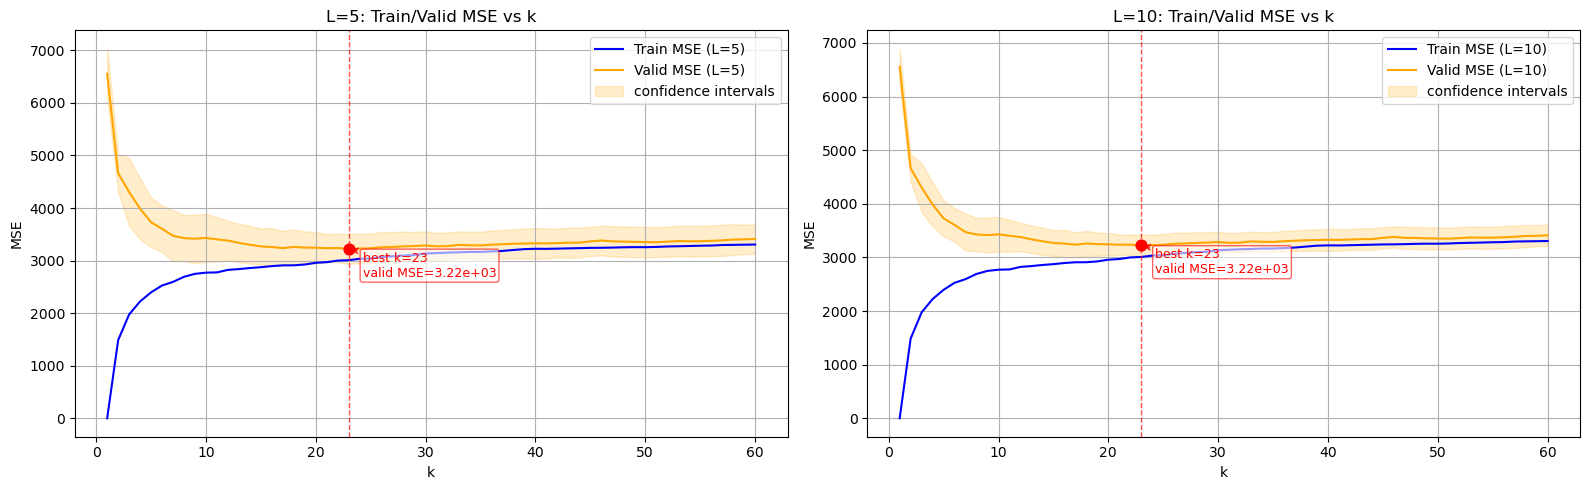

In [16]:
import matplotlib.pyplot as plt

k_values = np.arange(1, max_k + 1)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# L=5
best_idx_l5 = int(np.argmin(results_l5["valid_mse_means"]))
best_k_l5 = int(k_values[best_idx_l5])
best_mse_l5 = float(results_l5["valid_mse_means"][best_idx_l5])

axes[0].plot(k_values, results_l5["train_mse_means"], label="Train MSE (L=5)", color="blue")
axes[0].plot(k_values, results_l5["valid_mse_means"], label="Valid MSE (L=5)", color="orange")
axes[0].fill_between(
    k_values,
    results_l5["ci_lowers"],
    results_l5["ci_uppers"],
    color="orange",
    alpha=0.2,
    label="confidence intervals"
)

axes[0].scatter(best_k_l5, best_mse_l5, color="red", s=60, zorder=5)
axes[0].axvline(best_k_l5, color="red", linestyle="--", linewidth=1, alpha=0.7)
axes[0].annotate(
    f"best k={best_k_l5}\nvalid MSE={best_mse_l5:.3g}",
    xy=(best_k_l5, best_mse_l5),
    xytext=(10, -20),
    textcoords="offset points",
    color="red",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", alpha=0.6),
    arrowprops=dict(arrowstyle="->", color="red", lw=1),
)

axes[0].set_xlabel("k")
axes[0].set_ylabel("MSE")
axes[0].set_title("L=5: Train/Valid MSE vs k")
axes[0].legend()
axes[0].grid(True)

# L=10
best_idx_l10 = int(np.argmin(results_l10["valid_mse_means"]))
best_k_l10 = int(k_values[best_idx_l10])
best_mse_l10 = float(results_l10["valid_mse_means"][best_idx_l10])

axes[1].plot(k_values, results_l10["train_mse_means"], label="Train MSE (L=10)", color="blue")
axes[1].plot(k_values, results_l10["valid_mse_means"], label="Valid MSE (L=10)", color="orange")
axes[1].fill_between(
    k_values,
    results_l10["ci_lowers"],
    results_l10["ci_uppers"],
    color="orange",
    alpha=0.2,
    label="confidence intervals"
)

axes[1].scatter(best_k_l10, best_mse_l10, color="red", s=60, zorder=5)
axes[1].axvline(best_k_l10, color="red", linestyle="--", linewidth=1, alpha=0.7)
axes[1].annotate(
    f"best k={best_k_l10}\nvalid MSE={best_mse_l10:.3g}",
    xy=(best_k_l10, best_mse_l10),
    xytext=(10, -20),
    textcoords="offset points",
    color="red",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="red", alpha=0.6),
    arrowprops=dict(arrowstyle="->", color="red", lw=1),
)

axes[1].set_xlabel("k")
axes[1].set_ylabel("MSE")
axes[1].set_title("L=10: Train/Valid MSE vs k")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


#### Analysis
From the plots, we observe that very small values of $k$ (e.g., 1–3) lead to extremely low training errors but high validation errors, indicating overfitting. When $k$ increases to 23, the validation error reaches its minimum, which can be regarded as the optimal region. For large $k$ values (>23), both training and validation errors increase, and the model suffers from underfitting.

Comparing $L$=5 and $L$=10, both curves show similar trends, but the confidence intervals are wider for $L$=5, implying higher variance in the error estimates. In contrast, $L$=10 produces narrower confidence intervals and thus more stable performance estimates, at the cost of higher computational effort. Given the dataset size (309 training samples), $L$=10 provides a more reliable choice.

## 3 Question 3 Automatic Model Selection

### Task I. KnnRegressorCV implementation

In [17]:
from sklearn.base import BaseEstimator


class KnnRegressorCV(BaseEstimator):
    def __init__(self, ks=list(range(1, 21)), cv=LFold(5)):
        self.ks = ks
        self.cv = cv
        self.k_ = None  # the best k
        self.model_ = None  # the best model

    def fit(self, x, y):
        best_k = None
        best_score = float("inf")

        # iterate over each k
        for k in self.ks:
            val_errors = []
            for train_idx, val_idx in self.cv.split(x):
                # split data
                X_tr, y_tr = x[train_idx], y[train_idx]
                X_val, y_val = x[val_idx], y[val_idx]

                knn = KnnRegressor(k=k)
                knn.fit(X_tr, y_tr)
                y_val_pred = knn.predict(X_val)
                val_mse = mse(y_val, y_val_pred)
                val_errors.append(val_mse)

            mean_error = np.mean(val_errors)
            if mean_error < best_score:
                best_score = mean_error
                best_k = k

        # record the best k and the model
        self.k_ = int(best_k)
        self.model_ = KnnRegressor(k=self.k_).fit(x, y)
        return self

    def predict(self, x):
        return self.model_.predict(x)

In [18]:
l_fold = LFold(L=10)
knn_cv = KnnRegressorCV(ks=list(range(1, 21)), cv=l_fold)
knn_cv.fit(X, y)
knn_cv.predict(X_test)
print("Chosen k by inner CV:", knn_cv.k_)


Chosen k by inner CV: 19


### Task II. Nested cross-validation

Experimental setup: Outer CV is 10-fold, inner CV is 10-fold, and the tested k values are in the range [1, 60]

[Outer Fold] 1 completed, Best k: 20 with Test MSE: 3702.6724
[Outer Fold] 2 completed, Best k: 16 with Test MSE: 3814.6490
[Outer Fold] 3 completed, Best k: 18 with Test MSE: 3032.5382
[Outer Fold] 4 completed, Best k: 18 with Test MSE: 3377.8617
[Outer Fold] 5 completed, Best k: 10 with Test MSE: 3465.1839
[Outer Fold] 6 completed, Best k: 20 with Test MSE: 3184.8859
[Outer Fold] 7 completed, Best k: 18 with Test MSE: 2658.6661
[Outer Fold] 8 completed, Best k: 20 with Test MSE: 4207.0656
[Outer Fold] 9 completed, Best k: 24 with Test MSE: 2329.0017
[Outer Fold] 10 completed, Best k: 20 with Test MSE: 2886.2298
Average k: 18.40


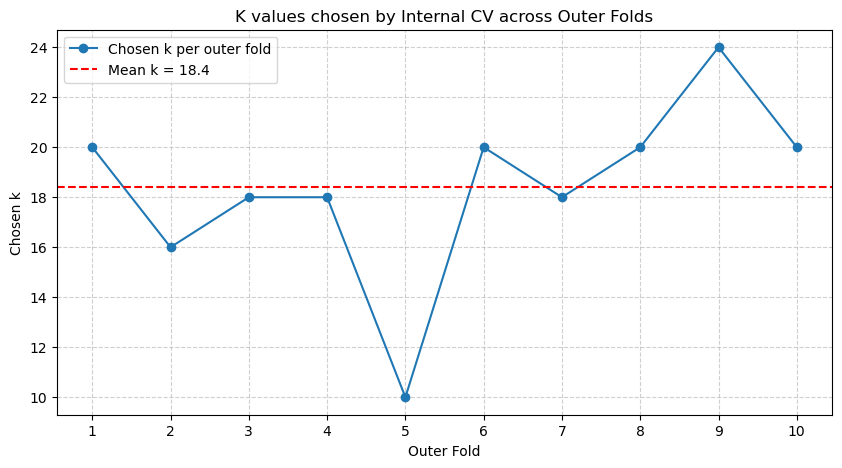

In [19]:
outer_cv = LFold(L=10, shuffle=True, random_state=18)
inner_cv = LFold(L=10, shuffle=True, random_state=18)

chosen_ks, test_mses = [], []
fold_count = 0
for tr_idx, val_idx in outer_cv.split(X):
    X_tr, y_tr = X[tr_idx], y[tr_idx]
    X_val, y_val = X[val_idx], y[val_idx]

    knn = KnnRegressorCV(ks=list(range(1,61)), cv=inner_cv).fit(X_tr, y_tr)
    chosen_ks.append(knn.k_)
    y_pred = knn.predict(X_val)
    # error of best model (in this outer fold)
    test_mses.append(mse(y_val, y_pred))
    fold_count += 1
    print(f"[Outer Fold] {fold_count} completed, Best k: {knn.k_} with Test MSE: {test_mses[-1]:.4f}")

# mean K
mean_k = np.mean(chosen_ks)
print(f"Average k: {mean_k:.2f}")

# plot the chosen k
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(chosen_ks) + 1), chosen_ks, marker='o', linestyle='-', label="Chosen k per outer fold")

# mean k
plt.axhline(y=mean_k, color='r', linestyle='--', label=f"Mean k = {mean_k:.1f}")

plt.xlabel("Outer Fold")
plt.ylabel("Chosen k")
plt.title("K values chosen by Internal CV across Outer Folds")
plt.xticks(range(1, len(chosen_ks) + 1))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


#### Analysis

The KNN regressor with internal cv selected an average k-value of 18.4 across the 10 outer folds. The individual k-values chosen ranged from 10 to 24, with most selections clustering around 18-20.

However, the mean k-value of 18.4 does **NOT** correspond to the optimal k-value with respect to the outer test sets. The lowest test MSE (2329.0017) was achieved in outer fold 9 with k=24.

First, the representativeness and stability of the dataset will affect the selection of the optimal model. We can see that in this experiment, the k values chosen by different outer folds vary greatly (10-24), which shows that there are large differences within the dataset. When the training subsets cannot well represent the overall data distribution, the selection by internal CV becomes unreliable.

Second, the choice of hyperparameters will also affect model selection. KNN is very sensitive to the k value, and small changes may lead to large performance fluctuations. If the model has many "local optimal points", internal CV can easily get trapped in them.

In addition, the design of cross-validation, such as the number of folds, splitting method, and random seed, will also affect the stability of the results.